# Fit the final model and make predictions

In [1]:
library(dplyr, warn=F)

In [2]:
selected_df = 'features/selected-features.tsv' %>%
  readr::read_tsv()
metapaths = dplyr::filter(selected_df, feature_type == 'dwpc')$feature
degrees = dplyr::filter(selected_df, feature_type == 'degree')$feature
col_types = list()
for (metapath in metapaths) {
  col_types[[metapath]] = readr::col_number()
}

In [3]:
feature_df = readr::read_tsv('features/features.tsv.bz2', col_types = col_types) %>%
  dplyr::mutate(prior_logit = boot::logit(prior_prob))

In [4]:
head(feature_df, 2)

,compound_id,compound_name,disease_id,disease_name,rel_type,status,prior_prob,CbG,CcSE,CdG,ellip.h,CtDrDuGaD,CtDtCbGaD,CtDtCtD,CtDtCuGaD,CtDuGcGuD,CuGaDpCtD,CuGiGuCpD,CuGuD,CuGuDpCtD,prior_logit
1,DB01048,Abacavir,DOID:10652,Alzheimer's disease,NA,0,0.004753,3,136,0,⋯,0,0.002638,0,0.0007788,0.00739,0,0,0,0,-5.344215
2,DB05812,Abiraterone,DOID:10652,Alzheimer's disease,NA,0,0.004753,8,71,0,⋯,0,0.005065,0,0.009089,0.001119,0,0,0,0,-5.344215


In [5]:
for (feature in degrees) {
    feature_df[[feature]] = asinh(feature_df[[feature]])
}

for (feature in metapaths) {
    x = feature_df[[feature]]
    feature_df[[feature]] = asinh(x / mean(x))
}

In [6]:
train_df = feature_df %>%
  dplyr::filter(prior_prob > 0)
  #dplyr::filter(is.na(rel_type) | rel_type == 'TREATS_CtD')
dim(train_df)

[1] 29799    90

In [7]:
X_train = train_df %>%
  dplyr::select(prior_logit, one_of(selected_df$feature)) %>%
  as.matrix()
dim(X_train)
y_train = train_df$status
table(y_train)

[1] 29799    75

y_train
    0     1 
29044   755 

In [8]:
penalty_factor = as.numeric(colnames(X_train) != 'prior_logit')
fit = hetior::glmnet_train(X = X_train, y = y_train, alpha = 0, s = 'lambda.1se', cores = 12, seed = 0,
    penalty.factor=penalty_factor, lambda.min.ratio=1e-6, nlambda=200)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



[1] 0.001164752

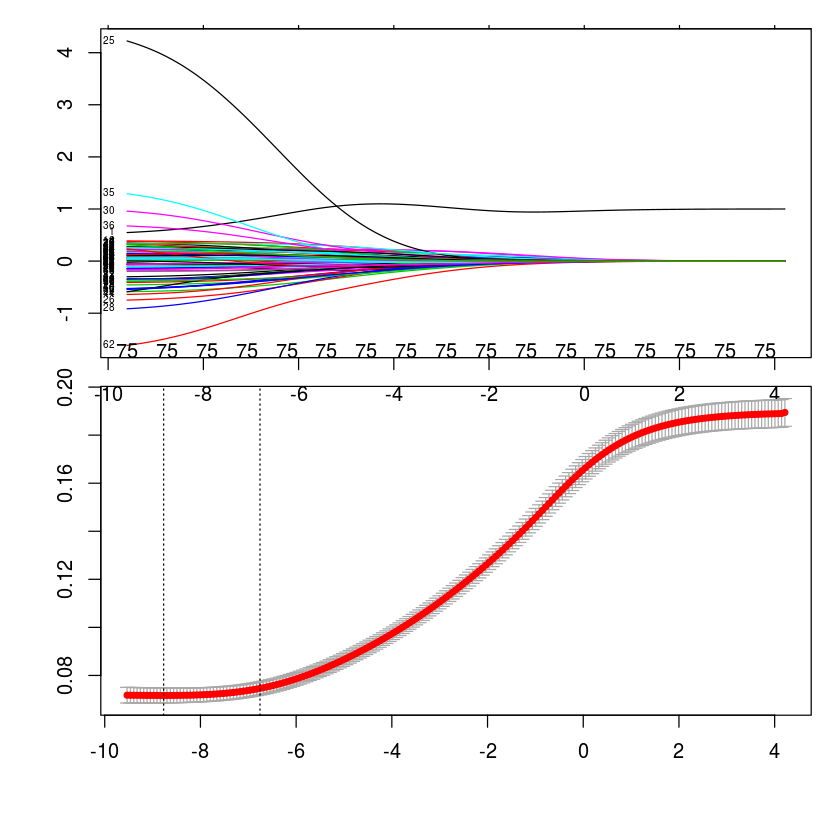

In [9]:
par(mfrow = c(2,1), oma = c(5,4,0,0) + 0.1, mar = c(0,0,1,1) + 0.1)
plot(fit$cv_model$glmnet.fit, xvar = "lambda", label = TRUE)
plot(fit$cv_model)
fit$cv_model$lambda.1se

In [10]:
fit$coef_df %>% readr::write_tsv('model/coefficient.tsv')

In [11]:
# training performance
fit$vtm[c('auroc', 'auprc', 'tjur')]

$auroc
[1] 0.9862909

$auprc
[1] 0.8174096

$tjur
[1] 0.5892236

In [12]:
# prior performance on training
vtm = hetior::calc_vtms(y_true = train_df$status, y_pred = train_df$prior_prob, T)
vtm[c('auroc', 'auprc', 'tjur')]

$auroc
[1] 0.850502

$auprc
[1] 0.1628536

$tjur
[1] 0.08693251

In [13]:
# Prevalence of positives as percent
y_true = feature_df$status
scales::percent(mean(y_true))

[1] "0.361%"

In [14]:
# prior performance on all observations
vtm = hetior::calc_vtms(y_true = feature_df$status, y_pred = feature_df$prior_prob)
vtm[c('auroc', 'auprc')]

$auroc
[1] 0.9791663

$auprc
[1] 0.1628536

In [15]:
sum(feature_df$prior_prob)

[1] 754.9903

In [16]:
X_all = feature_df %>%
  dplyr::mutate(prior_logit = boot::logit(mean(y_true))) %>%
  dplyr::select(one_of(colnames(X_train))) %>%
  as.matrix()
y_pred = hetior::glmnet_predict(fit$cv_model, X = X_all, s = 'lambda.1se')

In [17]:
predict_df = feature_df %>%
  dplyr::select(compound_id:rel_type, status) %>%
  dplyr::mutate(prediction = 100 * y_pred)

In [18]:
# Prediction performance
vtm = hetior::calc_vtms(y_true = predict_df$status, y_pred = predict_df$prediction / 100, T)
vtm[c('auroc', 'auprc', 'tjur')]

$auroc
[1] 0.9588598

$auprc
[1] 0.4094874

$tjur
[1] 0.2783512

In [19]:
predict_df %>%
  dplyr::arrange(desc(prediction)) %>%
  head(5)

,compound_id,compound_name,disease_id,disease_name,rel_type,status,prediction
1,DB01115,Nifedipine,DOID:10763,hypertension,TREATS_CtD,1,98.61839
2,DB00381,Amlodipine,DOID:10763,hypertension,TREATS_CtD,1,98.60193
3,DB00655,Estrone,DOID:10283,prostate cancer,TREATS_CtD,1,98.18825
4,DB00887,Bumetanide,DOID:10763,hypertension,TREATS_CtD,1,98.0578
5,DB04868,Nilotinib,DOID:2531,hematologic cancer,TREATS_CtD,1,97.98762


In [20]:
predict_df %>% readr::write_tsv('predictions/probabilities.tsv', na = '')